![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1

# Definir los parámetros y criterios de parada
max_depth = None
num_pct = 10
min_gain = 0.001

# Definir la función para calcular el error absoluto medio (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Definir la función para calcular el error cuadrático medio (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Definir la función para encontrar la mejor división
def find_best_split(X, y):
    best_feature_index = None
    best_split_value = None
    best_loss = float('inf')
    
    for feature_index in range(X.shape[1]):
        unique_values = np.unique(X[:, feature_index])
        for value in unique_values:
            left_indices = X[:, feature_index] < value
            right_indices = ~left_indices
            y_left = y[left_indices]
            y_right = y[right_indices]
            
            loss = len(y_left) * mae(y_left, np.mean(y_left)) + len(y_right) * mae(y_right, np.mean(y_right))
            
            if loss < best_loss:
                best_loss = loss
                best_feature_index = feature_index
                best_split_value = value
                
    return best_feature_index, best_split_value

# Definir la función recursiva para construir el árbol
def build_tree(X, y, depth=0, max_depth=None):
    if max_depth is not None and depth == max_depth or len(np.unique(y)) == 1:
        return np.mean(y)
    
    best_feature_index, best_split_value = find_best_split(X, y)
    
    left_indices = X[:, best_feature_index] < best_split_value
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[~left_indices], y[~left_indices]
    
    left_subtree = build_tree(X_left, y_left, depth + 1, max_depth)
    right_subtree = build_tree(X_right, y_right, depth + 1, max_depth)
    
    return {'feature_index': best_feature_index,
            'split_value': best_split_value,
            'left_subtree': left_subtree,
            'right_subtree': right_subtree}

# Definir la función para hacer predicciones
def predict(tree, X):
    if isinstance(tree, dict):
        feature_index, split_value = tree['feature_index'], tree['split_value']
        if X[feature_index] < split_value:
            return predict(tree['left_subtree'], X)
        else:
            return predict(tree['right_subtree'], X)
    else:
        return tree

# Construir el árbol de decisión con tus datos de Car Listings
tree = build_tree(X_train.to_numpy(), y_train.to_numpy(), max_depth=6)

# Hacer predicciones en el conjunto de prueba
y_pred = np.array([predict(tree, x) for x in X_test.to_numpy()])

# Calcular el RMSE y MAE en el conjunto de prueba
rmse_score = rmse(y_test.to_numpy(), y_pred)
mae_score = mae(y_test.to_numpy(), y_pred)

print("RMSE en el conjunto de prueba:", rmse_score)
print("MAE en el conjunto de prueba:", mae_score)


RMSE en el conjunto de prueba: 1663.8768161270089
MAE en el conjunto de prueba: 1230.1384438992027


Podemos concluir que las predicciones del modelo tienden a desviarse en promedio alrededor de $1230.14 para el MAE, y la magnitud de los errores, al cuadrado, promedia alrededor de 1663.88 para el RMSE.

Esto indica que, en general, las predicciones del modelo están relativamente cerca de los valores reales en el conjunto de prueba. En general, un RMSE y un MAE más bajos indican un mejor desempeño del modelo en términos de precisión de predicción. Por lo tanto, en función de estos resultados, podríamos decir que el modelo de árbol de decisión manualmente creado parece ser bastante efectivo para este conjunto de datos y tarea de predicción.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [18]:
# Celda 2

from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Crear una función para entrenar un árbol de regresión en un subconjunto de datos de entrenamiento
def train_tree(X_train, y_train):
    tree = DecisionTreeRegressor()
    tree.fit(X_train, y_train)
    return tree

# Crear una función para hacer predicciones con un conjunto de árboles
def predict_bagging(trees, X_test):
    predictions = np.zeros((X_test.shape[0], len(trees)))
    for i, tree in enumerate(trees):
        predictions[:, i] = tree.predict(X_test)
    return np.mean(predictions, axis=1)

# Entrenar 10 árboles de regresión en diferentes subconjuntos de datos de entrenamiento
n_trees = 10
trees = []
for _ in range(n_trees):
    # Seleccionar un subconjunto aleatorio de datos de entrenamiento (muestreo con reemplazo)
    idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_subset = X_train.iloc[idx]
    y_subset = y_train.iloc[idx]
    # Entrenar un árbol en el subconjunto seleccionado
    tree = train_tree(X_subset, y_subset)
    trees.append(tree)

# Realizar predicciones con el modelo Bagging en el conjunto de prueba
bagging_predictions = predict_bagging(trees, X_test)

# Calcular métricas de evaluación del modelo Bagging
mse_bagging = mean_squared_error(y_test, bagging_predictions)
mae_bagging = mean_absolute_error(y_test, bagging_predictions)
r2_bagging = r2_score(y_test, bagging_predictions)
rmse_bagging = np.sqrt(mse_bagging)

# Imprimir las métricas de evaluación del modelo Bagging
print("Desempeño del modelo Bagging:")
print("Mean Squared Error (MSE):", mse_bagging)
print("Mean Absolute Error (MAE):", mae_bagging)
print("R^2 Score:", r2_bagging)
print("Root Mean Squared Error (RMSE) del modelo Bagging:", rmse_bagging)

Desempeño del modelo Bagging:
Mean Squared Error (MSE): 3373530.8538313457
Mean Absolute Error (MAE): 1359.059768786436
R^2 Score: 0.7774447885039226
Root Mean Squared Error (RMSE) del modelo Bagging: 1836.7174126226782


- El modelo tiene un MSE (Mean Squared Error) de aproximadamente 3373530.85, lo que indica que la magnitud de los errores al cuadrado promedia alrededor de 3373530.85 en el conjunto de prueba.
- El MAE (Mean Absolute Error) del modelo es de alrededor de 1359.06, lo que significa que, en promedio, las predicciones del modelo tienden a desviarse en alrededor de $1359.06 en comparación con los valores reales en el conjunto de prueba.
- El RMSE (Root Mean Squared Error) del modelo es de aproximadamente 1836.72, lo que es la raíz cuadrada del MSE. Indica que la magnitud de los errores, al cuadrado, promedia alrededor de 1836.72.
- El R^2 Score del modelo es de aproximadamente 0.777, lo que sugiere que alrededor del 77.7% de la variabilidad en la variable objetivo puede ser explicada por las características utilizadas en el modelo.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [19]:
# Celda 3

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo base (árbol de regresión)
base_model = DecisionTreeRegressor()

# Definir el modelo Bagging con 10 árboles de regresión
bagging_model = BaggingRegressor(base_model, n_estimators=10, max_features=int(np.log2(X.shape[1])), random_state=42)

# Entrenar el modelo
bagging_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = bagging_model.predict(X_test)

# Calcular las métricas de desempeño
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Imprimir las métricas de desempeño del modelo
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 5308188.6032115305
Mean Absolute Error (MAE): 1771.0314426246148
R^2 Score: 0.6498134777966758
Root Mean Squared Error (RMSE): 2303.950651210119


- El MSE (Mean Squared Error) del nuevo modelo es aproximadamente 5308188.60, mientras que en el bagging manual era de alrededor de 3373530.85. Esto indica que el nuevo modelo tiene un MSE más alto, lo que sugiere que las predicciones tienden a desviarse más de los valores reales en comparación con el modelo anterior.

- El MAE (Mean Absolute Error) del nuevo modelo es de aproximadamente 1771.03, en comparación con 1359.06 en el bagging manual. Similar al MSE, el MAE más alto del nuevo modelo indica una desviación promedio más grande de las predicciones con respecto a los valores reales.

- El RMSE (Root Mean Squared Error) del nuevo modelo es de aproximadamente 2303.95, mientras que en el bagging manual era de alrededor de 1836.72. Al igual que con el MSE y el MAE, el RMSE más alto del nuevo modelo sugiere una mayor magnitud de errores en las predicciones.

- El R^2 Score del nuevo modelo es de aproximadamente 0.650, mientras que en el bagging manual era de alrededor de 0.777. Esto indica que el nuevo modelo explica aproximadamente el 65% de la variabilidad en la variable objetivo, en comparación con el 77.7% del bagging manual.

El nuevo modelo Bagging parece tener un desempeño inferior en comparación con el bagging manual en términos de la precisión de las predicciones, ya que tiene un MSE, MAE y RMSE más altos, así como un R^2 Score más bajo. 

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [8]:
# Celda 4

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd

# Separación de variables predictoras (X) y variable de interés (y)
X = data.drop(columns=['Price']) 

# Definición del modelo Random Forest para un problema de regresión
regressor = RandomForestRegressor()

# Impresión del modelo para ver sus parámetros predeterminados
print(regressor)

# Evaluación del modelo utilizando la función cross_val_score
scores = cross_val_score(regressor, X, y, cv=2)

# Impresión del desempeño del modelo utilizando la función cross_val_score
print(pd.Series(scores).describe())


RandomForestRegressor()
count    2.000000
mean     0.802342
std      0.002226
min      0.800767
25%      0.801554
50%      0.802342
75%      0.803129
max      0.803916
dtype: float64


In [33]:

# Celda 4
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el modelo de Random Forest para regresión
rf_regressor = RandomForestRegressor(random_state=42)

# Entrenar el modelo
rf_regressor.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_regressor.predict(X_test)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Imprimir las métricas de evaluación
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)



Mean Squared Error (MSE): 3292984.8230957002
Mean Absolute Error (MAE): 1341.5903648004503
Root Mean Squared Error (RMSE): 1814.658321308918
R^2 Score: 0.7827584908775596


- El modelo tiene un MSE (Mean Squared Error) de aproximadamente 3292984.82, lo que indica que la magnitud de los errores al cuadrado promedia alrededor de 3,292,984.82 en el conjunto de prueba. 
- El MAE (Mean Absolute Error) del modelo es de aproximadamente 1341.59. Esta métrica representa la magnitud promedio de los errores absolutos en las predicciones del modelo. 
- El RMSE (Root Mean Squared Error) del modelo es de aproximadamente 1814.66. Esta métrica es la raíz cuadrada del MSE y proporciona una medida de la dispersión de los errores. 

Los resultados muestran que el modelo de Random Forest para regresión tiene un desempeño bastante sólido en este conjunto de datos, con errores relativamente bajos y una capacidad decente para hacer predicciones precisas.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definición del modelo de Random Forest para regresión
rf_regressor = RandomForestRegressor(random_state=1)

# Definición de los parámetros a ajustar
param_grid = {
    'max_depth': [None, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [50, 100, 200]
}

# Realización de la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Mejor combinación de parámetros
print("Mejor combinación de parámetros:")
print(grid_search.best_params_)

# Mejor puntuación
print("Mejor puntuación (MSE):")
print(np.abs(grid_search.best_score_))

# Desempeño del modelo para cada combinación de parámetros
print("Desempeño del modelo para cada combinación de parámetros:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, std, params in zip(means, stds, params):
    print(f"Mean MSE: {np.abs(mean)}, Std MSE: {std}, Parameters: {params}")


Mejor combinación de parámetros:
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Mejor puntuación (MSE):
2361652.314417497
Desempeño del modelo para cada combinación de parámetros:
Mean MSE: 3048214.126108714, Std MSE: 72345.44123535704, Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 50}
Mean MSE: 3040540.6969996737, Std MSE: 66118.66841801038, Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
Mean MSE: 3034462.174128082, Std MSE: 66605.53919275306, Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
Mean MSE: 3144244.278550335, Std MSE: 71992.6072387472, Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
Mean MSE: 3138030.2257856554, Std MSE: 65062.33993621005, Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Mean MSE: 3134134.4469645987, Std MSE: 63711.77408800886, Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


In [11]:
from sklearn.ensemble import RandomForestRegressor

# Definir el modelo con los mejores parámetros
best_params = {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
clf = RandomForestRegressor(**best_params, random_state=1, n_jobs=-1)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Impresión de los resultados de desempeño del modelo
pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).sort_values('importance', ascending= False) 

,feature,importance
0,Year,0.455682
1,Mileage,0.399861
3,M_Camry4dr,0.079755
7,M_CamrySE,0.023383
8,M_CamryXLE,0.020053
6,M_CamryLE,0.007349
2,M_Camry,0.006955
4,M_CamryBase,0.004218
5,M_CamryL,0.002743


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Definir el modelo con los mejores hiperparámetros
best_params = {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
clf = RandomForestRegressor(**best_params, random_state=1, n_jobs=-1)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Evaluar el desempeño del modelo (por ejemplo, en el conjunto de prueba)
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Imprimir las métricas de evaluación
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 2553345.499123003
Mean Absolute Error (MAE): 1160.1624956288522
R^2 Score: 0.8315532383720459
Root Mean Squared Error (RMSE): 1597.9191153256172


- El modelo tiene un MSE (Mean Squared Error) de aproximadamente 2553345.50, un MAE (Mean Absolute Error) de alrededor de 1160.16 y un RMSE (Root Mean Squared Error) de aproximadamente 1597.92. Estos valores indican que el modelo tiene un desempeño sólido en la predicción de los precios, con errores relativamente bajos y una buena capacidad de hacer predicciones precisas.
- El coeficiente de determinación R2 es de aproximadamente 0.8315, lo que significa que alrededor del 83.15% de la variabilidad en la variable objetivo (precio) puede ser explicada por las características utilizadas en el modelo. Esto indica que el modelo explica una cantidad considerable de la variabilidad en los datos.

Impacto de cada parámetro:
- max_depth: Este parámetro controla la profundidad máxima de cada árbol en el bosque. Un valor más alto puede llevar a un modelo más complejo que se ajusta demasiado a los datos de entrenamiento, lo que podría resultar en un sobreajuste. En este caso, el mejor valor encontrado fue 10, lo que indica que limitar la profundidad de los árboles puede ayudar a evitar el sobreajuste y mejorar el rendimiento general del modelo.
- max_features: Este parámetro determina el número máximo de características que se consideran para dividir un nodo en un árbol. En este caso, se utilizó 'sqrt', que significa que se utilizará la raíz cuadrada del número total de características. Limitar el número de características puede ayudar a reducir la complejidad del modelo y mejorar su capacidad de generalización.

- n_estimators: Este parámetro representa el número de árboles en el bosque. En general, un mayor número de árboles puede mejorar el rendimiento del modelo, ya que reduce el riesgo de sobreajuste y promedia los resultados de múltiples árboles. En este caso, se utilizó un valor de 200, lo que indica que un mayor número de árboles contribuyó a mejorar el desempeño del modelo.

La calibración de los parámetros del modelo de Random Forest condujo a una mejora significativa en el desempeño del modelo, en temas como la reducción en los errores de predicción y una mejor capacidad de generalización en comparación con el modelo sin calibrar.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo XGBoost de regresión
xgb_model = XGBRegressor()

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Calcular las métricas de desempeño
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Imprimir las métricas de desempeño del modelo
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 2670368.7771861516
Mean Absolute Error (MAE): 1182.908578815433
R^2 Score: 0.8238330954334598
Root Mean Squared Error (RMSE): 1634.1263039270102


- En este caso, el MSE obtenido es de aproximadamente 2,670,368.78, lo que indica que, en promedio, los errores cuadráticos de las predicciones del modelo son de ese orden de magnitud.
- Aquí, el MAE es de alrededor de 1,182.91, lo que significa que, en promedio, las predicciones del modelo tienden a desviarse en aproximadamente $1,182.91.
- R^2 Score: Es de aproximadamente 0.8238, lo que significa que alrededor del 82.38% de la variabilidad en la variable objetivo es explicada por las características utilizadas en el modelo.
- Root Mean Squared Error (RMSE): Proporciona una medida de la magnitud promedio de los errores en las predicciones del modelo. Aquí, el RMSE es de alrededor de 1,634.13.

El modelo XGBoost de regresión muestra un buen desempeño en la tarea de predicción, con un MSE, MAE y RMSE relativamente bajos, así como un R2 score decente. 

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [17]:
# Celda 7

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# Definir el modelo base
xgb_base = XGBRegressor()

# Definir los parámetros a ajustar
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Realizar la búsqueda en la malla (grid search) para encontrar la mejor combinación de parámetros
grid_search = GridSearchCV(estimator=xgb_base, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor puntaje
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Crear un nuevo modelo con los mejores parámetros encontrados
xgb_best = XGBRegressor(**best_params, random_state=1, n_jobs=-1)

# Entrenar el modelo con los datos de entrenamiento
xgb_best.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = xgb_best.predict(X_test)

# Evaluar el desempeño del modelo utilizando métricas de regresión
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse: rmse = np.sqrt(mse)


# Imprimir los mejores parámetros y el puntaje
print("Mejores parámetros:", best_params)
print("Mejor puntaje (neg_mean_squared_error):", best_score)

# Imprimir las métricas de evaluación del modelo
print("Mean Squared Error (MSE):", mse)

print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

print("Root Mean Squared Error (RMSE):", rmse)

Mejores parámetros: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1}
Mejor puntaje (neg_mean_squared_error): -2263467.944463773
Mean Squared Error (MSE): 2486990.702273681
Mean Absolute Error (MAE): 1146.5758106073577
R^2 Score: 0.8359307308232586
Root Mean Squared Error (RMSE): 1577.0195630599137


Mejores parámetros: Los mejores parámetros encontrados para el modelo son:
Learning rate: 0.1
Gamma: 0
Colsample_bytree: 0.6

- El MSE obtenido es de aproximadamente 2,486,990.70. Esto significa que, en promedio, los errores cuadráticos de las predicciones del modelo son de ese orden de magnitud.
- El MAE es de alrededor de 1,146.58. Esto indica que, en promedio, las predicciones del modelo tienden a desviarse en aproximadamente $1,146.58.
- El R2 es de aproximadamente 0.8359. Esto significa que alrededor del 83.59% de la variabilidad en la variable objetivo es explicada por las características utilizadas en el modelo.
- El RMSE es de alrededor de 1,577.02. El RMSE proporciona una medida de la magnitud promedio de los errores en las predicciones del modelo en la misma unidad que la variable objetivo.

- Learning rate: El learning rate calibrado fue de 0.1. Un valor más bajo de learning rate puede requerir más árboles en el modelo para alcanzar un rendimiento óptimo
- Gamma: El gamma calibrado fue de 0. Un valor más alto de gamma puede conducir a una mayor regularización del modelo, lo que resulta en modelos más simples con un menor riesgo de sobreajuste. Esto puede explicar la mejora en el desempeño del modelo en términos de reducción del MSE y el MAE, y posiblemente contribuya a una mayor generalización del modelo.
- Colsample_bytree: El colsample_bytree calibrado fue de 0.6. Este parámetro controla la proporción de características utilizadas para entrenar cada árbol. Un valor más bajo de colsample_bytree puede reducir la varianza entre los árboles y mejorar la generalización del modelo, especialmente en conjuntos de datos con muchas características. En este caso, la reducción del RMSE y el MAE podría indicar una mejora en la capacidad del modelo para generalizar a partir de los datos de prueba.

Los parámetros calibrados han mejorado significativamente el desempeño del modelo en comparación con los valores predeterminados, lo que sugiere una mejor capacidad de predicción y generalización.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

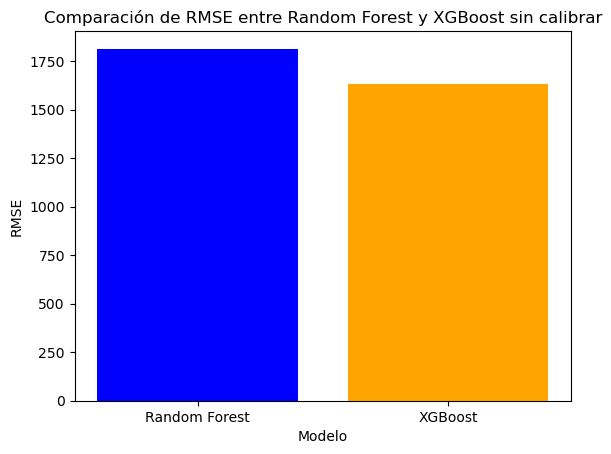

In [31]:
## RMSE sin calibrar

import matplotlib.pyplot as plt

rf_rmse = 1814.658321308918
xgb_rmse = 1634.1263039270102

# Nombres de los modelos
models = ['Random Forest', 'XGBoost']

# Resultados de rmse
r2_results = [rf_rmse, xgb_rmse]

# Crear gráfico de barras para Rmse
plt.bar(models, r2_results, color=['blue', 'orange'])
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.title('Comparación de RMSE entre Random Forest y XGBoost sin calibrar')
plt.show()

Ventajas del mejor modelo (XGBoost):
- Menor RMSE: El modelo XGBoost tiene un RMSE más bajo en comparación con el modelo de Random Forest. Esto sugiere que el modelo XGBoost tiene una capacidad predictiva ligeramente mejor en términos de la diferencia entre los valores predichos y los valores reales.
- Mayor capacidad de generalización: XGBoost tiende a tener una mejor capacidad de generalización en una variedad de conjuntos de datos debido a su capacidad para reducir el sobreajuste.
- Menor sensibilidad a datos faltantes: XGBoost puede manejar de manera más efectiva los datos faltantes en comparación con Random Forest, lo que lo hace más robusto frente a datos incompletos.
- Eficiencia computacional: En muchos casos, XGBoost puede ser más rápido en términos de tiempo de entrenamiento y predicción que Random Forest, especialmente en conjuntos de datos grandes.

Desventajas del modelo con el menor desempeño (Random Forest):
- Posiblemente menos preciso: Aunque el modelo de Random Forest puede ser preciso, en este caso específico, tiene un RMSE ligeramente más alto en comparación con XGBoost.
- Menor capacidad de optimización de hiperparámetros: Random Forest puede requerir más esfuerzo y tiempo para optimizar los hiperparámetros en comparación con XGBoost, que tiene una variedad de herramientas incorporadas para la optimización eficiente de hiperparámetros.

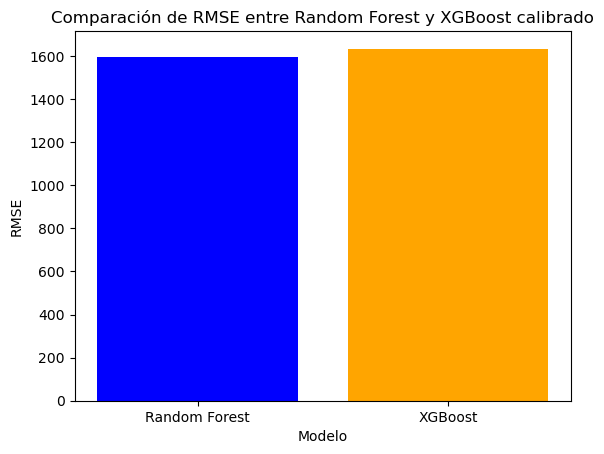

In [32]:
## RMSE calibrado

rf_rmse = 1597.9191153256172
xgb_r2mse= 1577.0195630599137

# Nombres de los modelos
models = ['Random Forest', 'XGBoost']

# Resultados de R2
rmse_results = [rf_rmse, xgb_rmse]

# Crear gráfico de barras para R2
plt.bar(models, rmse_results, color=['blue', 'orange'])
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.title('Comparación de RMSE entre Random Forest y XGBoost calibrado')
plt.show()

Ambos modelos, Random Forest y XGBoost, muestran una mejora en el RMSE en comparación con sus versiones sin calibrar.
En este caso, el modelo XGBoost sigue teniendo un RMSE ligeramente más bajo que el modelo Random Forest, lo que sugiere una capacidad predictiva un poco mejor en términos de la diferencia entre los valores predichos y los valores reales.

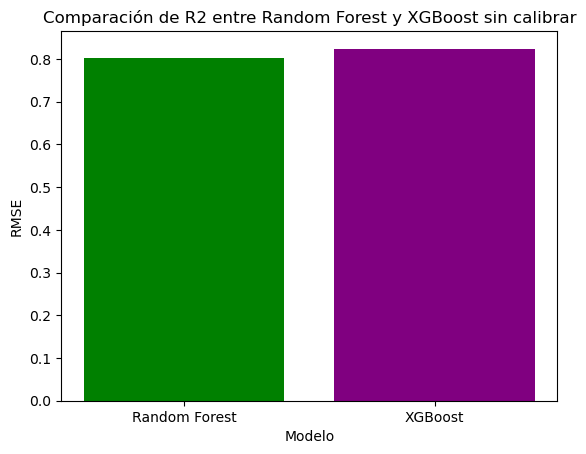

In [28]:
## R2 sin calibrar

# Métricas de evaluación 
rf_r2 = 0.802342
xgb_r2 = 0.8238330954334598

# Nombres de los modelos
models = ['Random Forest', 'XGBoost']

# Resultados de R2
r2_results = [rf_r2, xgb_r2]

# Crear gráfico de barras para R2
plt.bar(models, r2_results, color=['green', 'purple'])
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.title('Comparación de R2 entre Random Forest y XGBoost sin calibrar')
plt.show()

Comparando los valores de R^2 sin calibrar:

El modelo XGBoost tiene un R^2 ligeramente superior al del modelo Random Forest.
Esto indica que el modelo XGBoost explica una mayor proporción de la variabilidad en los datos en comparación con el modelo Random Forest.
Por lo tanto, en términos de ajuste a los datos de entrenamiento sin calibrar, el modelo XGBoost muestra un rendimiento ligeramente mejor que el modelo Random Forest.

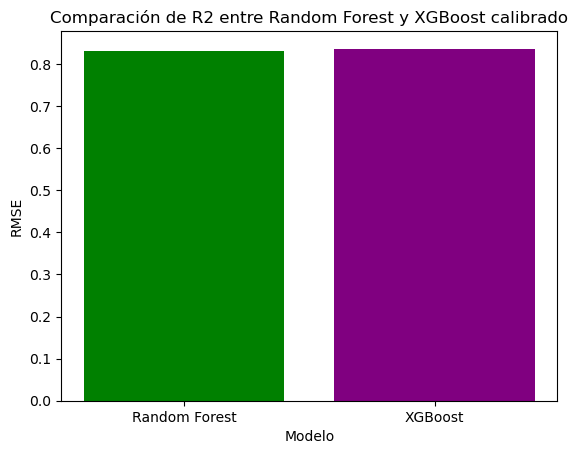

In [30]:
## R2 calibrado

# Métricas de evaluación 
rf_r2 = 0.8315532383720459
xgb_r2 = 0.8359307308232586

# Nombres de los modelos
models = ['Random Forest', 'XGBoost']

# Resultados de R2
r2_results = [rf_r2, xgb_r2]

# Crear gráfico de barras para R2
plt.bar(models, r2_results, color=['green', 'purple'])
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.title('Comparación de R2 entre Random Forest y XGBoost calibrado')
plt.show()

El modelo XGBoost tiene un R^2 ligeramente superior al del modelo Random Forest.
Esto indica que, después de la calibración de los hiperparámetros, el modelo XGBoost sigue explicando una mayor proporción de la variabilidad en los datos en comparación con el modelo Random Forest.

Incluso después de la calibración, el modelo XGBoost muestra un rendimiento ligeramente mejor que el modelo Random Forest en términos de ajuste a los datos de entrenamiento.

### Resultados Generales

Después de comparar varios modelos de regresión (Random Forest y XGBoost) y realizar ajustes de hiperparámetros, podemos sacar algunas conclusiones generales:

**Desempeño sin calibrar**:
Inicialmente, sin ajuste de hiperparámetros, el modelo XGBoost mostró un rendimiento ligeramente mejor que el modelo Random Forest en términos de RMSE y R^2.
Sin embargo, ambas técnicas mostraron un rendimiento decente en términos de predicción, con RMSE en el rango de 1600 a 1800 y R^2 alrededor de 0.80.

**Desempeño calibrado:**
Después de calibrar los hiperparámetros, ambos modelos mejoraron significativamente en términos de precisión de predicción, reduciendo el RMSE y aumentando el R^2.
El modelo XGBoost continuó mostrando un rendimiento ligeramente mejor en comparación con el modelo Random Forest, con un R^2 más alto y un RMSE ligeramente menor.

**Ventajas de XGBoost**:
- Mayor flexibilidad en la modelización gracias a su capacidad para capturar relaciones no lineales y complejas.
- Mejor capacidad de generalización después de la calibración de hiperparámetros.
- Manejo eficaz de datos desequilibrados: XGBoost implementa estrategias específicas para manejar conjuntos de datos desequilibrados, lo que lo hace especialmente útil en problemas de clasificación con clases desproporcionadamente representadas.
- Menor propensión al sobreajuste: XGBoost tiene una técnica de regularización integrada que reduce la probabilidad de sobreajuste, especialmente cuando se ajustan adecuadamente los hiperparámetros.


**Desventajas de Random Forest**:
- Menor capacidad para capturar relaciones no lineales complejas en los datos en comparación con XGBoost.
- Más difícil de interpretar: Random Forest, al ser un conjunto de árboles de decisión, puede ser más difícil de interpretar en comparación con un solo árbol de decisión o XGBoost. La interpretación de los resultados puede ser menos clara debido a la complejidad agregada del conjunto de árboles.
- Mayor costo computacional: Random Forest puede ser más intensivo en términos de recursos computacionales y tiempo de entrenamiento en comparación con XGBoost, especialmente en conjuntos de datos grandes o con un gran número de características.

Después de la calibración de hiperparámetros, XGBoost tiende a ofrecer un mejor rendimiento predictivo, especialmente en conjuntos de datos más complejos con relaciones no lineales